# © Artur Czarnecki. All rights reserved.
# Integrax framework – proprietary and confidential.
# Use, modification, or distribution without written permission is prohibited.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

# Simple LLM QA (Intergrax + LangGraph)

This notebook demonstrates the minimal integration between **Intergrax** and **LangGraph**.

Goal:

- Use an Intergrax **LLM adapter** as a node inside a **LangGraph** graph.
- Define a simple `State` that holds:
  - `messages`: chat-style messages (user, assistant, etc.)
  - `answer`: final answer returned by the node.
- Build a `StateGraph` with a single node `llm_answer_node`.
- Run the graph on a sample user question.

This notebook is the starting point. All more advanced examples (web search, RAG, hybrid agents, etc.) will follow the same pattern:  
**Intergrax component → wrapped as a LangGraph node → composed into a graph.**

In [2]:
from typing import TypedDict, Annotated, List, Optional
from langgraph.graph import StateGraph, END
from openai import Client
import os
from intergrax.llm_adapters import OpenAIChatResponsesAdapter
from intergrax.llm_adapters.base import ChatMessage
from intergrax.llm.conversational_memory import append_chat_messages

# Ensure your OpenAI API key is available in the environment
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "")

# LLM Adapter Initialization

In [3]:
# If your adapter uses a factory/registry instead of being instantiated directly, this is the place to plug it in.

llm_adapter = OpenAIChatResponsesAdapter(
    client=Client(),
    model="gpt-5-mini",
)

# State Definition and Node Implementation

In [4]:
class SimpleLLMState(TypedDict):
    """
    Graph state for the simple LLM QA example.

    Fields:
        - messages: list of chat messages (system / user / assistant).
        - answer: final answer producted by the LLM node.
    """
    messages: Annotated[List[ChatMessage], append_chat_messages]
    answer: Optional[str]



def llm_answer_node(state: SimpleLLMState) -> SimpleLLMState:
    """
    LangGraph node that calls the Intergrax LLM adapter.

    Expected `state`:
      - `messages`: a list of ChatMessage (Intergrax native)

    Behavior:
      - Sends the messages to the Intergrax LLM adapter.
      - Returns a partial state update containing the `answer`.

    Note:
      - We return only the delta (answer). LangGraph will merge this
        with the previous state automatically.
      - Adjust the call below (`llm_adapter.chat`) to match the
        actual API of your Intergrax adapter.
    """
    messages = state.get("messages", [])
        
    answer_text = llm_adapter.generate_messages(
        messages
    )

    return {
        "answer": answer_text
    }

# Build the Graph

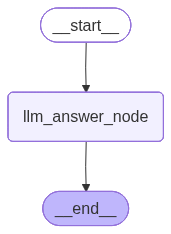

In [5]:
from IPython.display import display, Image

# Build the LangGraph StateGraph for SimpleLLMState
simple_graph_builder = StateGraph(SimpleLLMState)

# Register node
simple_graph_builder.add_node(llm_answer_node.__name__, llm_answer_node)

# Set entry point (starting node)
simple_graph_builder.set_entry_point(llm_answer_node.__name__)

# Define the graph flow: llm_answer -> END
simple_graph_builder.add_edge(llm_answer_node.__name__, END)

# compile and display graph
simple_graph = simple_graph_builder.compile()

display(Image(simple_graph.get_graph().draw_mermaid_png()))

# Run a Sample Query

In [6]:
initial_state: SimpleLLMState = {
    "messages": [
        ChatMessage(
            role="user",
            content="Explain in 3-4 sentances what is the most popular LLM framework ?",
        )
    ],
    "answer": None
}

result = simple_graph.invoke(initial_state)

print("=== ANSWER ===")
print(result['answer'])

=== ANSWER ===
Hugging Face Transformers is widely regarded as the most popular framework for working with large language models. It offers a huge open-source model hub, unified APIs, and ready-to-use tokenizers and architectures that run on PyTorch, TensorFlow, and JAX. Its broader ecosystem (Datasets, Tokenizers, Accelerate, and inference tools), extensive documentation, and active community make fine-tuning, evaluation, and deployment much easier. For production tasks teams often pair it with PyTorch/TensorFlow or specialized runtimes, but Transformers remains the go-to developer-facing toolkit.
